In [1]:
%pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations
from dataclasses import dataclass, field
from itertools import chain
from copy import deepcopy
import csv
import pprint as pp
import graphviz

pprt = pp.PrettyPrinter(indent=2)
pprint = lambda x: pprt.pprint(x)

word_dictionary_csv = """word,pronunciation,pos,note
い,i,X,
お,o,N,tail
おと,oto,N,sound
おと,oto,V,drop
が,ga,P,NOM
こ,ko,N,child
こがた,kogata,N,miniature
し,shi,N,city
し,shi,X, 
た,ta,A,PAST
たい,tai,N,sea bream
たい,tai,A,WANT
とし,toshi,N,year
ね,ne,V,sleep
ねこ,neko,N,cat
を,o,P,ACC
会員,kaiin,N,member
机,tsukue,N,desk"""

connection_table_csv = """POS,A,N,P,V,X,START,END
START,1,1,1,1,0,0,0
END,1,1,0,0,1,0,0
A,1,1,1,0,0,0,0
N,1,1,1,1,0,0,1
P,1,1,1,1,0,0,1
V,0,0,1,1,1,0,0
X,1,1,1,1,0,0,1"""

costs_of_pos_csv = """pos,cost
A,25
N,20
P,10
V,30
X,5"""

costs_of_pairs_of_pos_csv = """POS,A,N,P,V,X,START,END
A,70,0,30,0,5,0,10
N,30,20,5,30,0,0,40
P,15,10,0,10,0,0,0
V,0,0,0,60,5,0,0
X,15,10,0,15,0,0,10
START,30,10,50,20,0,0,0
END,0,40,0,0,10,0,0
"""

In [3]:
def word_dict_parser(raw_csv) -> dict:
    _dict = {}
    for row in csv.DictReader(raw_csv.splitlines()):
        try:
            _dict[row['word']].append(row)
        except KeyError:
            _dict.update({row['word']: [row]})
    return _dict


NEKO_WORD_DICT = word_dict_parser(word_dictionary_csv)
pprint(NEKO_WORD_DICT)

{ 'い': [{'note': '', 'pos': 'X', 'pronunciation': 'i', 'word': 'い'}],
  'お': [{'note': 'tail', 'pos': 'N', 'pronunciation': 'o', 'word': 'お'}],
  'おと': [ {'note': 'sound', 'pos': 'N', 'pronunciation': 'oto', 'word': 'おと'},
          {'note': 'drop', 'pos': 'V', 'pronunciation': 'oto', 'word': 'おと'}],
  'が': [{'note': 'NOM', 'pos': 'P', 'pronunciation': 'ga', 'word': 'が'}],
  'こ': [{'note': 'child', 'pos': 'N', 'pronunciation': 'ko', 'word': 'こ'}],
  'こがた': [ { 'note': 'miniature',
             'pos': 'N',
             'pronunciation': 'kogata',
             'word': 'こがた'}],
  'し': [ {'note': 'city', 'pos': 'N', 'pronunciation': 'shi', 'word': 'し'},
         {'note': ' ', 'pos': 'X', 'pronunciation': 'shi', 'word': 'し'}],
  'た': [{'note': 'PAST', 'pos': 'A', 'pronunciation': 'ta', 'word': 'た'}],
  'たい': [ { 'note': 'sea bream',
            'pos': 'N',
            'pronunciation': 'tai',
            'word': 'たい'},
          {'note': 'WANT', 'pos': 'A', 'pronunciation': 'tai', 'word': 'たい

In [4]:
def connection_table_parser(raw_csv) -> dict:
    _dict = {}
    for row in csv.DictReader(raw_csv.splitlines()):
        _dict.update({row['POS']: {
            'START': row['START'] == '1',
            'END': row['END'] == '1',
            'A': row['A'] == '1',
            'N': row['N'] == '1',
            'P': row['P'] == '1',
            'V': row['V'] == '1',
            'X': row['X'] == '1'
        }})
    return _dict

    
NEKO_CONN_TABLE = connection_table_parser(connection_table_csv)
pprint(NEKO_CONN_TABLE)

{ 'A': { 'A': True,
         'END': False,
         'N': True,
         'P': True,
         'START': False,
         'V': False,
         'X': False},
  'END': { 'A': True,
           'END': False,
           'N': True,
           'P': False,
           'START': False,
           'V': False,
           'X': True},
  'N': { 'A': True,
         'END': True,
         'N': True,
         'P': True,
         'START': False,
         'V': True,
         'X': False},
  'P': { 'A': True,
         'END': True,
         'N': True,
         'P': True,
         'START': False,
         'V': True,
         'X': False},
  'START': { 'A': True,
             'END': False,
             'N': True,
             'P': True,
             'START': False,
             'V': True,
             'X': False},
  'V': { 'A': False,
         'END': False,
         'N': False,
         'P': True,
         'START': False,
         'V': True,
         'X': True},
  'X': { 'A': True,
         'END': True,
         'N': T

In [5]:
def costs_of_pos_parser(raw_csv) -> dict:
    _dict = {}
    for row in csv.DictReader(raw_csv.splitlines()):
        _dict.update({row['pos']: row['cost']})
    return _dict


NEKO_POS_COSTS = costs_of_pos_parser(costs_of_pos_csv)
pprint(NEKO_POS_COSTS)

{'A': '25', 'N': '20', 'P': '10', 'V': '30', 'X': '5'}


In [6]:
def costs_of_pairs_of_pos_parser(raw_csv) -> dict:
    _dict = {}
    for row in csv.DictReader(raw_csv.splitlines()):
        _dict.update({row['POS']: {
            'START': int(row['START']),
            'END': int(row['END']),
            'A': int(row['A']),
            'N': int(row['N']),
            'P': int(row['P']),
            'V': int(row['V']),
            'X': int(row['X'])
        }})
    return _dict


NEKO_PAIR_COSTS_TABLE = costs_of_pairs_of_pos_parser(costs_of_pairs_of_pos_csv)
pprint(NEKO_PAIR_COSTS_TABLE)

{ 'A': {'A': 70, 'END': 10, 'N': 0, 'P': 0, 'START': 0, 'V': 0, 'X': 5},
  'END': {'A': 0, 'END': 0, 'N': 40, 'P': 0, 'START': 0, 'V': 0, 'X': 10},
  'N': {'A': 30, 'END': 40, 'N': 20, 'P': 5, 'START': 0, 'V': 30, 'X': 0},
  'P': {'A': 15, 'END': 0, 'N': 10, 'P': 0, 'START': 0, 'V': 10, 'X': 0},
  'START': {'A': 30, 'END': 0, 'N': 10, 'P': 50, 'START': 0, 'V': 20, 'X': 0},
  'V': {'A': 0, 'END': 0, 'N': 0, 'P': 0, 'START': 0, 'V': 60, 'X': 5},
  'X': {'A': 15, 'END': 10, 'N': 10, 'P': 0, 'START': 0, 'V': 15, 'X': 0}}


In [7]:
class Result:
    def __init__(self, result: any, is_ok: bool):
        self.result = result
        self._is_ok = is_ok

    def is_ok(self):
        return self._is_ok
    
    def is_err(self):
        return self._is_ok != True
    
    def unwrap(self) -> any:
        if self._is_ok:
            return self.result
        else:
            raise RuntimeError("panic while unwrap!")


@dataclass
class Morpheme:
    word: str
    size: int
    pos: str
    raw: dict[str, str]
    cost: int = 0


@dataclass
class MorphemeNode:
    m: Morpheme
    previous_node: list[MorphemeNodePair] = field(default_factory=list) 
    next_node: list[MorphemeNodePair] = field(default_factory=list)


@dataclass
class MorphemeNodePair:
    nodename: str
    pair_cost: int


@dataclass
class MorphologicalAnalyserJaSolution:
    all: dict
    with_all_cost: dict
    min_cost: dict
    with_conneciton: dict


class MorphologicalAnalyserJa:
    def __init__(self, _word_dict: dict, _conn_table: dict, _cost_pos, _cost_pair) -> None:
        self._origin: str = ''
        self._dict: dict = _word_dict
        self._conn: dict = _conn_table
        self._cost_pos: dict = _cost_pos
        self._cost_pair: dict = _cost_pair
        self._origin_length = 0
        self._word_node: dict[int, list[Morpheme]] = {}
        self._connection_node: dict[int, list[MorphemeNode]] = {}
    
    def _init_input(self, _input: str) -> None:
        self._origin = _input
        self._origin_length = len(_input)
        self._init_all_node()

    def _init_all_node(self) -> None:
        _init = dict((i, []) for i in range(len(self._origin)))
        self._word_node = deepcopy(_init)
        self._connection_node = deepcopy(_init)
    
    def _find_word(self, word: str) -> list[dict[str, str]]:
        return list(chain(*list(self._dict[k] for k in list(filter(lambda x: x.startswith(word), list(self._dict.keys()))))))
    
    def _try_add_node(self, cursor: int, data: dict) -> None:
        data_length = len(data['word'])
        if data_length > 1:
            if data['word'] != self._origin[cursor:cursor + data_length]:
                return
        try:
            next_cursor = cursor + 1
            node = self._word_node[next_cursor]
            if data_length <= self._origin_length - cursor:
                self._add_node(cursor, data_length, data)
        except KeyError:
            if data_length == 1:
                self._add_node(cursor, data_length, data)
    
    def _add_node(self, cursor: int, data_length: int, data: dict) -> None:
        self._word_node[cursor].append(
            Morpheme(data['word'], data_length, data['pos'], data, self._cost_pos[data['pos']])
            )
    
    def _find_all_solution(self) -> None:
        for cursor, word in enumerate(self._origin):
            list(map(lambda w: self._try_add_node(cursor, w), self._find_word(word)))
    
    def _try_connect_node(self, cursor: int, lm: list[Morpheme]) -> None:
        for m in lm:
            node = MorphemeNode(m)
            if cursor == 0 and self._conn['START'][m.pos]:
                    node.previous_node.append(
                        MorphemeNodePair('START', self._cost_pair['START'][m.pos])
                    )
            else:
                for prev_cursor in range(cursor, -1, -1):
                    for n in self._word_node[prev_cursor]:
                        if (n.size + prev_cursor == cursor) and self._conn[n.pos][m.pos]:
                            node.previous_node.append(
                                MorphemeNodePair(
                                    f'{n.word}_{n.pos}_{prev_cursor}',
                                    self._cost_pair[n.pos][m.pos]
                                )
                            )
            try:
                next_cursor = cursor + m.size
                for n in self._word_node[next_cursor]:
                    if self._conn[m.pos][n.pos]:
                        node.next_node.append(
                            MorphemeNodePair(
                                f'{n.word}_{n.pos}_{next_cursor}',
                                self._cost_pair[m.pos][n.pos]
                            )
                        )
            except KeyError:
                if self._conn['END'][m.pos]:
                    node.next_node.append(
                        MorphemeNodePair('END', self._cost_pair[m.pos]['END'])
                    )
            self._connection_node[cursor].append(node)

    def _find_connection_solution(self) -> None:
        for cursor, lm in self._word_node.items():
            self._try_connect_node(cursor, lm)

    def analyse(self, _input: str) -> Result:
        self._init_input(_input)
        try:
            self._find_all_solution()
            self._find_connection_solution()
            return Result(
                MorphologicalAnalyserJaSolution(self._word_node, {}, {}, self._connection_node),
                is_ok=True)
        except Exception as e:
            pprint(e)
            return Result(None, False)

In [8]:
analyser_ja: MorphologicalAnalyserJa = MorphologicalAnalyserJa(
    NEKO_WORD_DICT, NEKO_CONN_TABLE, NEKO_POS_COSTS, NEKO_PAIR_COSTS_TABLE)
input_string = "ねこがたいをおとした"
solution_result: Result = analyser_ja.analyse(input_string)
if solution_result.is_ok():
    solution: MorphologicalAnalyserJaSolution = solution_result.unwrap()
    pprint(solution.with_conneciton)
else:
    print("Morphological analysis failed.")

{ 0: [ MorphemeNode(m=Morpheme(word='ね',
                               size=1,
                               pos='V',
                               raw={ 'note': 'sleep',
                                     'pos': 'V',
                                     'pronunciation': 'ne',
                                     'word': 'ね'},
                               cost='30'),
                    previous_node=[ MorphemeNodePair(nodename='START',
                                                     pair_cost=20)],
                    next_node=[]),
       MorphemeNode(m=Morpheme(word='ねこ',
                               size=2,
                               pos='N',
                               raw={ 'note': 'cat',
                                     'pos': 'N',
                                     'pronunciation': 'neko',
                                     'word': 'ねこ'},
                               cost='20'),
                    previous_node=[ MorphemeNodePair(nodename='START'

In [9]:
# dirty and fast
class MorphologicalAnalysisGraph:
    def __init__(self, solution):
        graphviz.set_jupyter_format('png')
        self._g = None
        self._init_graph()
        self._solution: MorphologicalAnalyserJaSolution = solution
    
    def _init_graph(self):
        self._g = graphviz.Digraph()
        self._g.attr(rankdir='LR')
        self._g.attr('node', shape='box')
        
    def _set_start(self, with_cost=False):
        self._g.node('START')
        for node in self._solution.with_conneciton[0]:
            for p in node.previous_node:
                if p.nodename == 'START':
                    node_name = f'{node.m.word}_{node.m.pos}_{0}'
                    if with_cost:
                        self._g.edge('START', node_name, label=str(p.pair_cost))
                    else:
                        self._g.edge('START', node_name)
    
    def _set_end(self, with_cost=False):
        self._g.node('END')
    
    def _add_node(self, cursor: int, mn: MorphemeNode, with_cost=False):
        node_name = f'{mn.m.word}_{mn.m.pos}_{cursor}'
        if with_cost:
            self._g.node(node_name, xlabel=str(mn.m.cost))
            for _next in mn.next_node:
                if mn.previous_node and _next.pair_cost:
                    self._g.edge(node_name, _next.nodename, label=str(_next.pair_cost), )
        else:
            self._g.node(node_name)
            if mn.previous_node:
                for _next in mn.next_node:
                    self._g.edge(node_name, _next.nodename)
        
    
    def draw_all_solution(self):
        self._init_graph()
        self._set_start()
        for k, v in self._solution.with_conneciton.items():
            for m in v:
                self._add_node(k, m)
        self._set_end()
        return self._g
    
    def draw_with_cost(self):
        self._init_graph()
        self._set_start(with_cost=True)
        for k, v in self._solution.with_conneciton.items():
            for m in v:
                self._add_node(k, m, with_cost=True)
        self._set_end(with_cost=True)
        return self._g


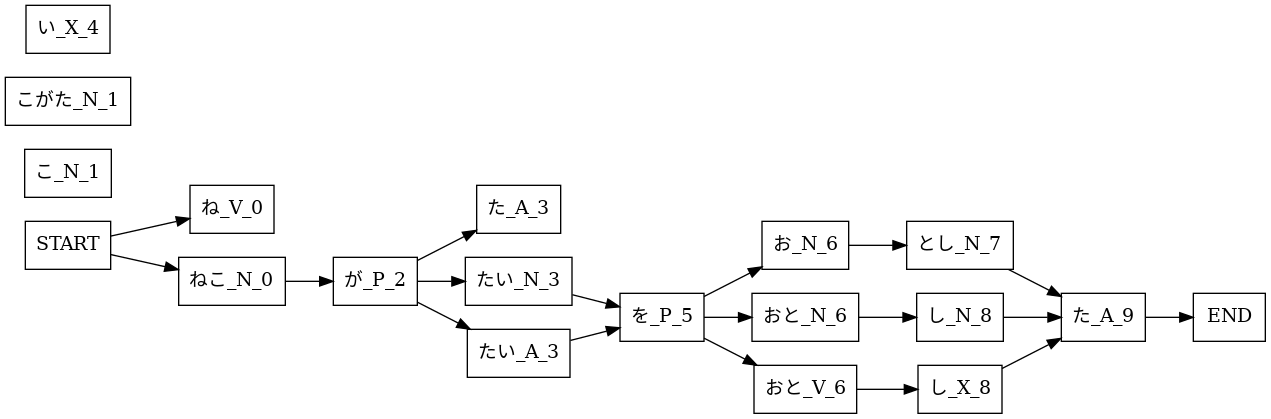

In [10]:
neko_graph = MorphologicalAnalysisGraph(solution)
neko_graph.draw_all_solution()

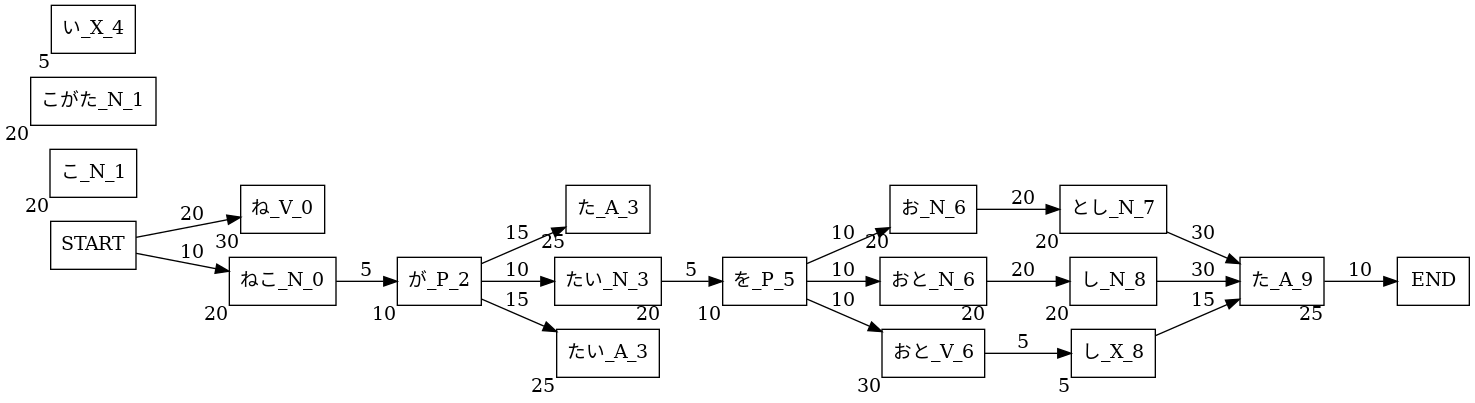

In [11]:
neko_graph.draw_with_cost()

In [12]:
heiwa_word_dictionary_csv = """word,pronunciation,pos,note
い,i,V,
いの,ino,V,
いわ,iwa,N,
く,ku,X,
つ,tu,N,
つよ,tuyo,A,
の,no,V,
へ,he,P,
へい,hei,N, 
へいわ,heiwa,N,peace
よく,yoku,N,
る,ru,X,
わ,wa,N,
を,o,P,ACC"""

heiwa_connection_table_csv = """POS,A,N,P,V,X,START,END
START,1,1,1,1,0,0,0
END,0,1,0,0,1,0,0
A,1,1,1,0,1,0,0
N,1,1,1,1,0,0,1
P,1,1,1,1,0,0,1
V,0,0,0,1,1,0,0
X,1,1,0,1,0,0,1"""

heiwa_costs_of_pos_csv = """pos,cost
A,25
N,20
P,10
V,30
X,5"""

heiwa_costs_of_pairs_of_pos_csv = """POS,A,N,P,V,X,START,END
A,70,0,0,0,5,0,0
N,30,20,5,30,0,0,40
P,15,10,0,10,0,0,0
V,0,0,0,60,5,0,0
X,15,10,0,15,0,0,10
START,30,10,50,20,0,0,0
END,0,40,0,0,10,0,0
"""

analyser_ja: MorphologicalAnalyserJa = MorphologicalAnalyserJa(
    word_dict_parser(heiwa_word_dictionary_csv), connection_table_parser(heiwa_connection_table_csv),
    costs_of_pos_parser(heiwa_costs_of_pos_csv), costs_of_pairs_of_pos_parser(heiwa_costs_of_pairs_of_pos_csv))
input_string = "つよくへいわをいのる"
solution_result: Result = analyser_ja.analyse(input_string)
if solution_result.is_ok():
    solution: MorphologicalAnalyserJaSolution = solution_result.unwrap()
else:
    print("Morphological analysis failed.")

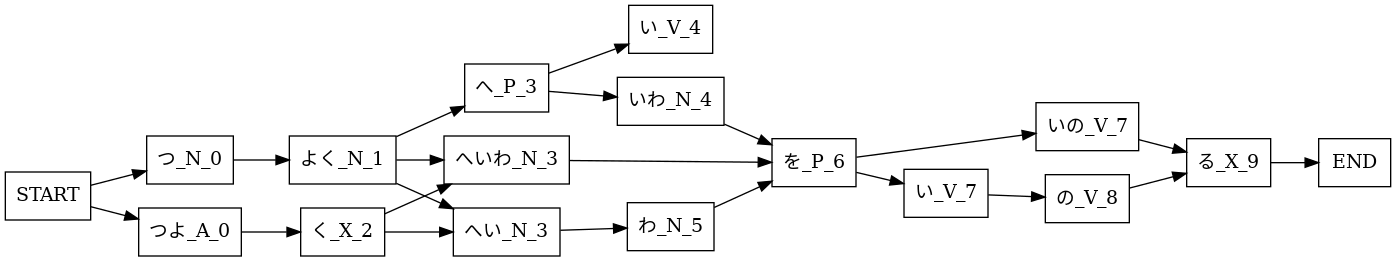

In [13]:
heiwa_graph = MorphologicalAnalysisGraph(solution)
heiwa_graph.draw_all_solution()

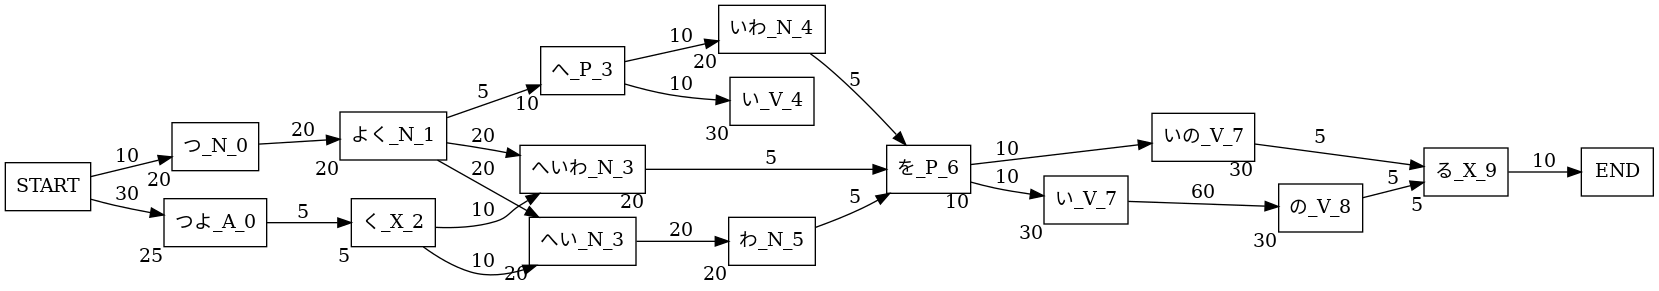

In [14]:
heiwa_graph.draw_with_cost()